## Imports

In [2]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers
import shap

## Load data

In [3]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
patch_ds = xr.open_dataset(patch_files[0])
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))
meta_ds = pd.read_csv(csv_files[0])

In [4]:
patch_ds

<xarray.Dataset>
Dimensions:           (p: 370, row: 144, col: 144)
Coordinates:
  * p                 (p) int32 0 1 2 3 4 5 6 7 ... 363 364 365 366 367 368 369
  * row               (row) int32 0 1 2 3 4 5 6 ... 137 138 139 140 141 142 143
  * col               (col) int32 0 1 2 3 4 5 6 ... 137 138 139 140 141 142 143
Data variables: (12/26)
    lon               (p, row, col) float32 ...
    lat               (p, row, col) float32 ...
    i                 (p, row, col) int32 ...
    j                 (p, row, col) int32 ...
    x                 (p, row, col) float32 ...
    y                 (p, row, col) float32 ...
    ...                ...
    MLCAPE_prev       (p, row, col) float32 ...
    USHR6_prev        (p, row, col) float32 ...
    VSHR6_prev        (p, row, col) float32 ...
    SBLCL_prev        (p, row, col) float32 ...
    U_BUNK_prev       (p, row, col) float32 ...
    V_BUNK_prev       (p, row, col) float32 ...
Attributes: (12/36)
    Conventions:             CF-1.6
    title:                   NCARSTORM Storm Patches for run 20101024-0000 me...
    object_variable:         REFL_COM
    start_hour:              12
    end_hour:                35
    HRRR_alt_end_hour:       46
    ...                      ...
    single_step:             True
    label_type:              gamma
    model_map_file:          /glade/work/cbecker/hagelslag/mapfiles/ncar_stor...
    mask_file:               None
    run_date_format:         %Y%m%d-%H%M
    json:                    False

In [5]:
meta_ds

,Step_ID,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20101024-0000_12_13_000_00,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-98.41019,...,0.90735,51.23550,21.53869,1.41172,0,0,0,0,0,0
1,d01_REFL_COM_20101024-0000_12_13_000_01,d01_REFL_COM_20101024-0000_12_13_000,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-97.69198,...,0.85356,26.92719,14.02906,1.13923,0,0,0,0,0,0
2,d01_REFL_COM_20101024-0000_12_12_001_00,d01_REFL_COM_20101024-0000_12_12_001,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-95.15486,...,0.71815,8.65894,6.02569,0.74301,0,0,0,0,0,0
3,d01_REFL_COM_20101024-0000_12_13_002_00,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 12:00:00+00:00,12,12,1,-94.39792,...,0.58687,7.89825,6.39509,-1.28875,0,0,0,0,0,0
4,d01_REFL_COM_20101024-0000_12_13_002_01,d01_REFL_COM_20101024-0000_12_13_002,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-24 13:00:00+00:00,13,13,2,-94.21008,...,0.91899,27.65443,10.90375,0.32912,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,d01_REFL_COM_20101024-0000_35_35_238_00,d01_REFL_COM_20101024-0000_35_35_238,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.94177,...,0.44428,6.31100,5.65396,1.29480,0,0,0,0,0,0
366,d01_REFL_COM_20101024-0000_35_35_239_00,d01_REFL_COM_20101024-0000_35_35_239,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-85.16997,...,0.85947,79.05277,40.41106,0.12811,0,0,0,0,0,0
367,d01_REFL_COM_20101024-0000_35_35_240_00,d01_REFL_COM_20101024-0000_35_35_240,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-88.18374,...,0.92145,18.05184,7.01316,0.99009,0,0,0,0,0,0
368,d01_REFL_COM_20101024-0000_35_35_241_00,d01_REFL_COM_20101024-0000_35_35_241,NCARSTORM,d01,2010-10-24 00:00:00+00:00,2010-10-25 11:00:00+00:00,35,11,1,-82.50549,...,0.93744,14.44305,5.02817,-0.19595,0,0,0,0,0,0


In [6]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 150
train_split = int(num_files*0.7)
val_split = int(num_files*0.8)
variables = ["REFL_COM_curr", "masks"]
data_list = []
for p, patch_file in enumerate(patch_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_train = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
train_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_val = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
val_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_test = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
test_masks = xr.concat(data_list, dim="p")["masks"]

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_2

In [7]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_train = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_val = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_test = xr.concat(csv_data_list, dim="p").to_array().transpose()

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTO

In [8]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(output_train.shape)
print(output_val.shape)
print(output_test.shape)

(34061, 144, 144, 1)
(4300, 144, 144, 1)
(12985, 144, 144, 1)
(34061, 2)
(4300, 2)
(12985, 2)


## Normalize data

In [9]:
# Normalize the input data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [10]:
# Normalize the output data
output_scale_stats = pd.DataFrame(index=range(output_train.shape[-1]), columns=["mean", "sd"])
output_scale_stats.loc[:, "mean"] = output_train.mean(dim="p")
output_scale_stats.loc[:, "sd"] = output_train.std(dim="p")
output_train_norm = xr.DataArray(coords=output_train.coords, dims=output_train.dims)
output_val_norm = xr.DataArray(coords=output_val.coords, dims=output_val.dims)
output_test_norm = xr.DataArray(coords=output_test.coords, dims=output_test.dims)
for i in range(output_train.shape[-1]):
    output_train_norm[:, i] = (output_train[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_val_norm[:, i] = (output_val[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]
    output_test_norm[:, i] = (output_test[:, i] - output_scale_stats.loc[i, "mean"]) / output_scale_stats.loc[i, "sd"]

## RICNN

In [13]:
ricnn_model = models.Sequential()
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_model.add(GDL_layers.RotInvPool())
ricnn_model.add(layers.Flatten())
ricnn_model.add(layers.Dense(32, activation='relu'))
ricnn_model.add(layers.Dense(2))

2022-08-15 08:38:24.208849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 08:38:26.890123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


In [14]:
ricnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 142, 142, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 71, 71, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 32, 32, 4, 64)    1

In [15]:
ricnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [16]:
ricnn_history = ricnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10


2022-08-15 08:38:34.709758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1065/1065 [==============================] - 90s 69ms/step - loss: 0.2683 - mse: 0.2683 - val_loss: 0.1228 - val_mse: 0.1228
Epoch 2/10
1065/1065 [==============================] - 73s 68ms/step - loss: 0.1335 - mse: 0.1335 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 3/10
1065/1065 [==============================] - 73s 68ms/step - loss: 0.0926 - mse: 0.0926 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 4/10
1065/1065 [==============================] - 72s 68ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0556 - val_mse: 0.0556
Epoch 5/10
1065/1065 [==============================] - 72s 68ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 6/10
1065/1065 [==============================] - 72s 68ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0637 - val_mse: 0.0637
Epoch 7/10
1065/1065 [==============================] - 73s 68ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 8/10
1065/1065 [==============================] - 73s

## CNN

In [17]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(144, 144, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(2))

In [18]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [19]:
cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [20]:
cnn_history = cnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10
1065/1065 [==============================] - 16s 14ms/step - loss: 0.2757 - mse: 0.2757 - val_loss: 0.1635 - val_mse: 0.1635
Epoch 2/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.1699 - mse: 0.1699 - val_loss: 0.1023 - val_mse: 0.1023
Epoch 3/10
1065/1065 [==============================] - 15s 14ms/step - loss: 0.1261 - mse: 0.1261 - val_loss: 0.0834 - val_mse: 0.0834
Epoch 4/10
1065/1065 [==============================] - 15s 14ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.0874 - val_mse: 0.0874
Epoch 5/10
1065/1065 [==============================] - 15s 15ms/step - loss: 0.0790 - mse: 0.0790 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 6/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0613 - val_mse: 0.0613
Epoch 7/10
1065/1065 [==============================] - 15s 14ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 8/10
1065/1065 [==========================

## History Plots

(0.0, 0.2878351153805852)

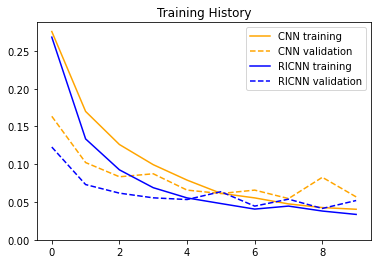

In [21]:
F, ax = plt.subplots()
ax = plt.gca()
a = ax.plot(cnn_history.history['mse'], label='CNN training', color='orange')
b = ax.plot(cnn_history.history['val_mse'], label='CNN validation', color='orange', linestyle='dashed')
c = ax.plot(ricnn_history.history['mse'], label='RICNN training', color='blue')
d = ax.plot(ricnn_history.history['val_mse'], label='RICNN validation', color='blue', linestyle='dashed')
ax.legend()
ax.set_title("Training History")
ax.set_ylim(bottom=0)

## Save and load models

In [22]:
ricnn_model.save("saved_models/ricnn_shap/ricnn_model")
cnn_model.save("saved_models/ricnn_shap/cnn_model")

INFO:tensorflow:Assets written to: saved_models/ricnn_shap/ricnn_model/assets


INFO:tensorflow:Assets written to: saved_models/ricnn_shap/cnn_model/assets


INFO:tensorflow:Assets written to: saved_models/ricnn_shap/cnn_model/assets


In [11]:
ricnn_model = tf.keras.models.load_model("saved_models/ricnn_shap/ricnn_model")
cnn_model = tf.keras.models.load_model("saved_models/ricnn_shap/cnn_model")

2022-08-17 10:49:55.909586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-17 10:49:56.428415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


## Evaluate models

In [24]:
ricnn_model.evaluate(input_test_norm, output_test_norm)

406/406 [==============================] - 11s 26ms/step - loss: 0.0664 - mse: 0.0664


[0.06642357259988785, 0.06642357259988785]

In [25]:
cnn_model.evaluate(input_test_norm, output_test_norm)

406/406 [==============================] - 3s 8ms/step - loss: 0.0746 - mse: 0.0746


[0.07456615567207336, 0.07456615567207336]

## Investigate SHAP Values

In [16]:
masker_blur = shap.maskers.Image("blur(144,144)", input_train_norm[0].shape)
ricnn_exp = shap.Explainer(ricnn_model, masker_blur, output_names=["major axis", "minor axis"])
cnn_exp = shap.Explainer(cnn_model, masker_blur, output_names=["major axis", "minor axis"])

In [17]:
ricnn_shap_val = ricnn_exp(input_test_norm[0:5].values, max_evals=60000)
rot_ricnn_shap_val = ricnn_exp(np.rot90(input_test_norm[0:5].values, axes=(1, 2), k=1), max_evals=60000)
cnn_shap_val = cnn_exp(input_test_norm[0:5].values, max_evals=60000)
rot_cnn_shap_val = cnn_exp(np.rot90(input_test_norm[0:5].values, axes=(1, 2), k=1), max_evals=60000)

2022-08-16 09:50:29.011294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
100%|█████████▉| 59950/59998 [01:39<00:00, 575.62it/s]
60008it [01:39, 573.73it/s]                           
100%|█████████▉| 59970/59998 [01:37<00:00, 566.39it/s]
Partition explainer: 6it [08:49, 105.81s/it]                      
100%|█████████▉| 59940/59998 [01:39<00:00, 567.90it/s]
60000it [01:39, 568.48it/s]                           
100%|█████████▉| 59950/59998 [01:41<00:00, 575.88it/s]
60008it [01:41, 576.02it/s]                           
100%|█████████▉| 59960/59998 [01:41<00:00, 576.22it/s]
Partition explainer: 6it [08:50, 106.12s/it]                      
100%|█████████▉| 59930/59998 [00:49<00:00, 1103.65it/s]
Partition explainer: 6it [04:34, 54.86s/it]                       
100%|█████████▉| 59900/59998 [00:51<00:00, 1077.24it/s]
Partition explainer: 6it [04:46, 57.38s/it]                       


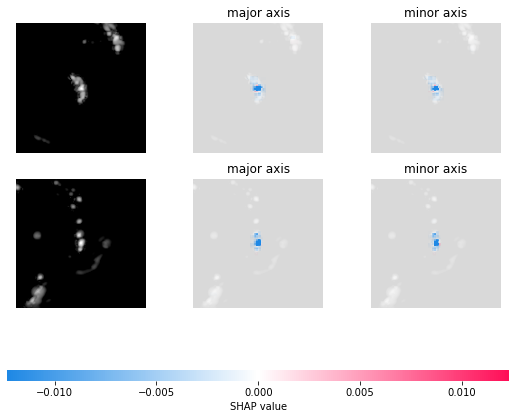

In [18]:
shap.image_plot(ricnn_shap_val, input_test_norm[0:2].values, labels=np.array(['major axis', 'minor axis']*10).reshape(-1, 4))

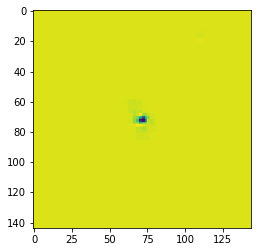

In [19]:
plt.imshow(ricnn_shap_val.values[0, :, :, 0, 0])

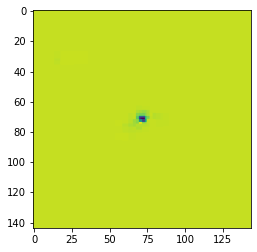

In [20]:
plt.imshow(rot_ricnn_shap_val.values[0, :, :, 0, 0])

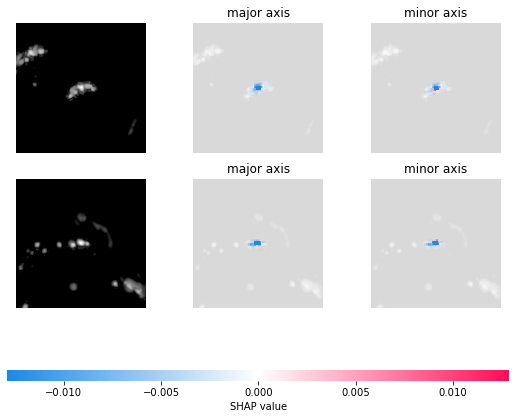

In [21]:
shap.image_plot(rot_ricnn_shap_val, np.rot90(input_test_norm[0:2].values, axes=(1, 2), k=1), labels=np.array(['major axis', 'minor axis']*10).reshape(-1, 4))

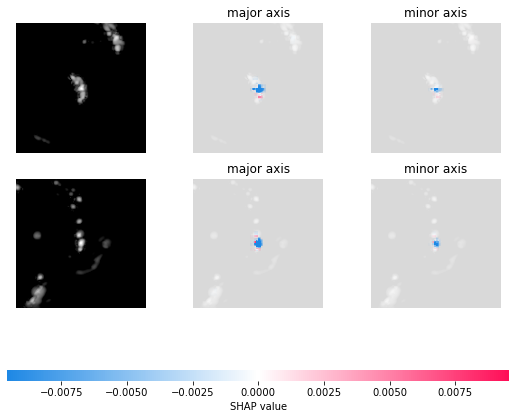

In [22]:
shap.image_plot(cnn_shap_val, input_test_norm[0:2].values, labels=np.array(['major axis', 'minor axis']*5).reshape(-1, 2))

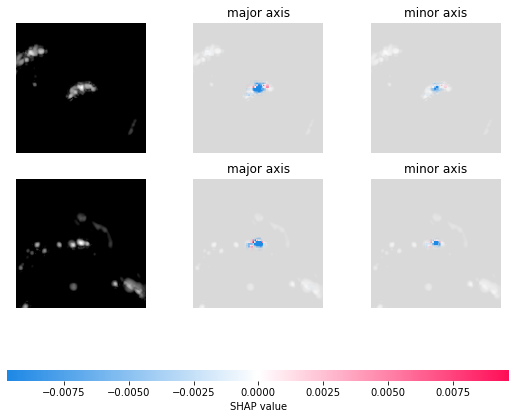

In [23]:
shap.image_plot(rot_cnn_shap_val, np.rot90(input_test_norm[0:2].values, axes=(1, 2), k=1), labels=np.array(['major axis', 'minor axis']*10).reshape(-1, 4))

In [12]:
def compute_grad(model, input_data, output_index):
    with tf.GradientTape() as tape:
        images = tf.convert_to_tensor(input_data)
        tape.watch(images)
        preds = model(images)[:, output_index]
        return tape.gradient(preds, images)

In [24]:
tr_min = input_train_norm.min()
tr_max = input_train_norm.max()

In [21]:
indices = np.argsort(output_test_norm[:, 0]).values[0:20]
imgs = input_test_norm[indices]

In [23]:
grads = compute_grad(ricnn_model, imgs, 0)

In [33]:
g_min = np.min(grads)
g_max = np.max(grads)
g_minmax = np.max([np.abs(g_min), np.abs(g_max)])

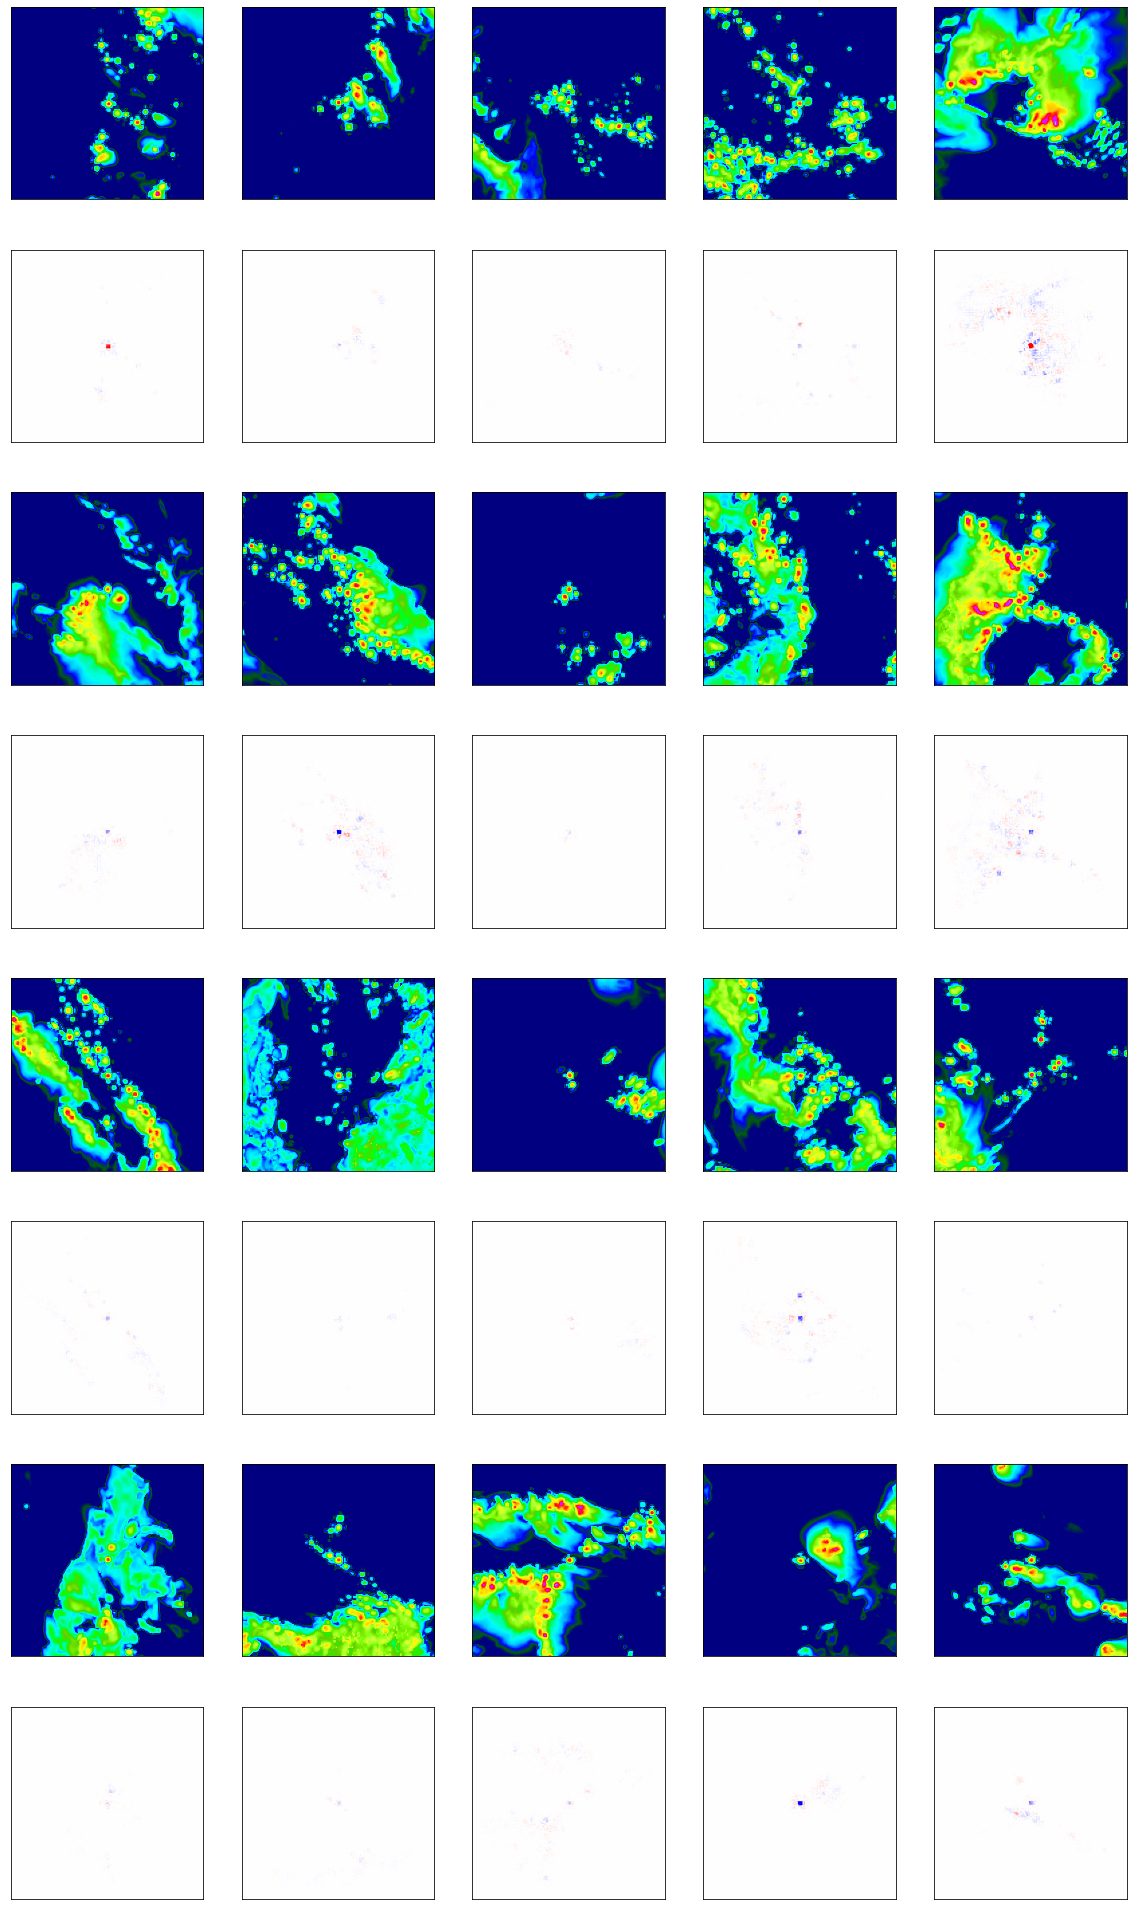

In [43]:
F, ax = plt.subplots(8, 5, figsize=(20, 35))
F.set_facecolor('white')
for i in range(4):
    for j in range(5):
        ax[i*2, j].imshow(imgs[5*i + j], cmap='gist_ncar', clim=(tr_min, tr_max))
        ax[i*2, j].set_xticks([])
        ax[i*2, j].set_yticks([])
        ax[i*2 + 1, j].imshow(imgs[5*i + j], cmap='binary', clim=(tr_min, tr_max), alpha=0.2)
        ax[i*2 + 1, j].set_xticks([])
        ax[i*2 + 1, j].set_yticks([])
        ax[i*2 + 1, j].imshow(imgs[5*i + j]*grads[5*i + j], cmap='bwr', clim=(-g_minmax, g_minmax))

In [116]:
with tf.GradientTape() as tape:
    image = tf.convert_to_tensor(input_test_norm[12589:12590])
    tape.watch(image)
    preds = ricnn_model(image)[:, 0]
    grad = tape.gradient(preds, image)

In [14]:
image = input_test_norm[12589:12590]

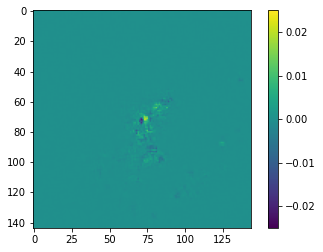

In [15]:
plt.imshow(tf.squeeze(grad*image), vmin=-0.025, vmax=0.025)
plt.colorbar()

In [118]:
with tf.GradientTape() as tape:
    image = tf.convert_to_tensor(input_test_norm[12589:12590])
    tape.watch(image)
    preds = ricnn_model(image)[:, 1]
    grad = tape.gradient(preds, image)

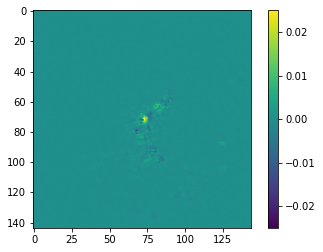

In [119]:
plt.imshow(tf.squeeze(grad*image), vmin=-0.025, vmax=0.025)
plt.colorbar()

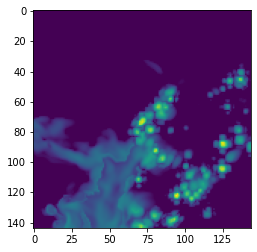

In [99]:
plt.imshow(tf.squeeze(image))

In [89]:
with tf.GradientTape() as tape:
    image = tf.convert_to_tensor(np.rot90(input_test_norm[0:1], axes=(1, 2), k=1))
    tape.watch(image)
    preds = ricnn_model(image)
    grad = tape.gradient(preds, image)

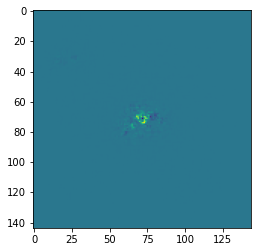

In [90]:
plt.imshow(tf.squeeze(grad*image))

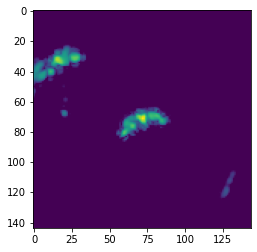

In [91]:
plt.imshow(tf.squeeze(image))

In [96]:
np.argmax(output_test_norm[:, 0].values)

12859

In [ ]:
preds = ricnn_model.predict(input_test_norm)

In [ ]:
preds_err = np.mean(np.square(preds - output_test_norm), 1)

In [ ]:
unnorm_preds = preds * output_scale_stats.loc[0, "sd"].values + output_scale_stats.loc[0, "mean"].values

In [ ]:
preds_err_df = pd.DataFrame(
    np.column_stack(
        (unnorm_preds[:, 0], unnorm_preds[:, 1], preds_err, output_test[:, 0], output_test[:, 1])
    ),
    columns=["pred_maj_axis", "pred_min_axis", "pred_err", "maj_axis", "min_axis"]
)

In [ ]:
preds_err_df

In [ ]:
sorted_preds_df = preds_err_df.sort_values("maj_axis")

In [ ]:
F, ax = plt.subplots(figsize=(20, 5))
ax.plot(sorted_preds_df["maj_axis"], sorted_preds_df["pred_err"])

In [ ]:
high_err_examples = sorted_preds_df[sorted_preds_df.pred_err >= 1]
high_err_examples

In [ ]:
F, ax = plt.subplots(figsize=(20, 5))
ax.scatter(high_err_examples.maj_axis, high_err_examples.pred_err)

In [ ]:
# Plot high error examples sorted by increasing major axis lengths
F, ax = plt.subplots(9, 10, figsize=(20, 20))
for num, ind in enumerate(high_err_examples.index):
    i = num // 10
    j = num % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])

In [ ]:
v_high_err_examples = sorted_preds_df[sorted_preds_df.pred_err >= 8]
v_high_err_examples

In [ ]:
F, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, ind in enumerate(v_high_err_examples.index):
    ax[i].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i].imshow(mask, alpha=.5, cmap='spring')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
F.set_facecolor("white")

In [ ]:
# Plot the 100 worst errors
F, ax = plt.subplots(10, 10, figsize=(20, 20))
for num, ind in enumerate(preds_err_df.sort_values("pred_err")[-100:].index):
    i = num // 10
    j = num % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
F.set_facecolor("white")

In [ ]:
latent_predictor = tf.keras.Model(ricnn_model.inputs, ricnn_model.layers[-2].output)

In [ ]:
ricnn_l_preds = latent_predictor.predict(input_test_norm)

In [ ]:
latent_predictor.predict(np.rot90(input_test_norm[0:1], 0, axes=(1, 2)))

In [ ]:
cnn_latent_predictor = tf.keras.Model(cnn_model.inputs, cnn_model.layers[-2].output)

In [ ]:
cnn_l_preds = cnn_latent_predictor.predict(np.rot90(input_test_norm, 0, axes=(1, 2)))

In [ ]:
cnn_latent_predictor.predict(np.rot90(input_test_norm[0:1], 3, axes=(1, 2)))

In [ ]:
ricnn_uniq, ricnn_counts = np.unique(ricnn_l_preds.nonzero()[0], return_counts=True)
ricnn_counts.mean()

In [ ]:
plt.hist(ricnn_counts, np.arange(1, 16))

In [ ]:
F, ax = plt.subplots(11, 10, figsize=(20, 20))
for n, ind in enumerate(ricnn_uniq[ricnn_counts >= 12]):
    i = n // 10
    j = n % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
F.set_facecolor("white")

In [ ]:
F, ax = plt.subplots(10, 10, figsize=(20, 20))
for n, ind in enumerate(ricnn_uniq[ricnn_counts == 4][0:100]):
    i = n // 10
    j = n % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
F.set_facecolor("white")

In [ ]:
np.unique(ricnn_l_preds.nonzero()[1]).shape

In [ ]:
cnn_uniq, cnn_counts = np.unique(cnn_l_preds.nonzero()[0], return_counts=True)
cnn_counts.mean()

In [ ]:
plt.hist(cnn_counts, np.arange(1, 11))

In [ ]:
np.unique(cnn_l_preds.nonzero()[1]).shape

In [ ]:
F, ax = plt.subplots(10, 10, figsize=(20, 20))
for n, ind in enumerate(cnn_uniq[cnn_counts >= 8][-100:]):
    i = n // 10
    j = n % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
F.set_facecolor("white")

In [ ]:
F, ax = plt.subplots(10, 10, figsize=(20, 20))
for n, ind in enumerate(cnn_uniq[cnn_counts == 5][0:100]):
    i = n // 10
    j = n % 10
    ax[i, j].imshow(input_test_norm[ind, :, :, 0])
    mask = np.ma.masked_where(test_masks[ind, :, :] == 0, test_masks[ind, :, :])
    ax[i, j].imshow(mask, alpha=.5, cmap='spring')
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
F.set_facecolor("white")